In [1]:
import numpy as np
import pandas as pd
import os
import PIL # install pillow - pip install Pillow
import PIL.Image
import tensorflow as tf
#from tensorflow import keras
import tensorflow_datasets as tfds # need to install this seperately - pip install tensorflow_datasets
import pathlib
from skimage import io
import datetime
import matplotlib.pyplot as plt
import h5py # pip install h5py
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.gridspec as gridspec
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import glob
import os
import shutil

In [2]:
#run this cell to generate a .csv file to be used for ml

def read_data(path):
    appended_data = []
    df = [pd.read_csv(filename,header=21) for filename in glob.glob(path)] 
    peak_abs=np.zeros((np.shape(df)[0]))
    for file in range(np.shape(df)[0]):
        #df[file][['wavelength','absorbance', 'reference', 'sample_signal']]=df[file]['data'].str.split(expand=True)
        df[file]['wavelength'] = pd.to_numeric(df[file]['Wavelength (nm)'], errors='coerce')
        df[file]['absorbance'] = pd.to_numeric(df[file]['Absorbance (AU)'], errors='coerce')
        df[file]['absorbance']=df[file]['absorbance']/np.max(df[file]['absorbance'])
         # remove data col, as not needed
        df[file]=df[file].drop(['wavelength', 'Absorbance (AU)', 'Reference Signal (unitless)', 'Sample Signal (unitless)', 'Wavelength (nm)'], axis=1)
        #appended_data.append(df[file]) #appends all values in col
        appended_data.append(df[file].T) #228x1 appends each acq in row -- 900 x 228x1
        
        #peak_abs[file]=df[file]['wavelength'][np.argmax(df[file]['absorbance'])]
    appended_data = pd.concat(appended_data) # all 900 acquisition appended together
    #appended_data_coton.to_excel('appended.xlsx') # write to csv    
    return appended_data, peak_abs


# def read_data(path):
#     appended_data=[]
#     for file in range(np.shape(df)[0]):
#         df[file] = pd.DataFrame(df[file])
#         #df_cotton[file]=df_cotton[file].drop(['wavelength'], axis=1)
#         appended_data.append(df[file]) #228x1
#     appended_data = pd.concat(appended_data) # all 900 acquisition appended together
#     appended_data.to_csv('df_cotton.csv', index=False)

#cotton
path_cotton=r'C:\Users\devTe\Desktop\ML\samples\Cotton\**\*.csv' # path of file to read
appended_data_cotton, peak_abs_cotton = read_data(path_cotton) 
class_cotton=np.zeros(len(appended_data_cotton)).astype(int)
appended_data_cotton.insert(np.shape(appended_data_cotton)[1], "class", class_cotton)

#wool
path_wool=r'C:\Users\devTe\Desktop\ML\samples\wool\**\*.csv'
appended_data_wool, peak_abs_wool =read_data(path_wool) # read file 1000x227x4
class_wool=np.ones(len(appended_data_wool)).astype(int)
appended_data_wool.insert(np.shape(appended_data_wool)[1], "class", class_wool)

#polyester
path_polyester=r'C:\Users\devTe\Desktop\ML\samples\polyester\**\*.csv'
appended_data_polyester, peak_abs_polyester =read_data(path_polyester) # read file 1000x227x4
class_polyester=np.ones(len(appended_data_polyester)).astype(int) * 2
appended_data_polyester.insert(np.shape(appended_data_polyester)[1], "class", class_polyester)

#check
print("Cotton data : \n {}".format (appended_data_cotton.head()))
print("Wool data : \n {}".format (appended_data_wool.head()))
print("Polyester data : \n {}".format (appended_data_polyester.head()))

#concatenate data frames
data = [appended_data_cotton, appended_data_wool, appended_data_polyester]
data=pd.concat(data) # contains both cottorn and wool with class 0 and 1

print("data-head : \n {}".format (data.head()))
print("data-tail : \n {}".format (data.tail()))

#save to csv
#data.to_csv('data_cotton_wool_polyester.csv', index=False)  # only use when you want to add new class

#check
data['class'].value_counts()



Cotton data : 
                    0         1         2         3         4         5  \
absorbance -0.032214 -0.007049 -0.001102 -0.000654 -0.008188 -0.012234   
absorbance -0.031801  0.001236  0.007400  0.005055 -0.003947 -0.004986   
absorbance -0.025959  0.004670  0.002298  0.011410  0.001458 -0.006218   
absorbance -0.026155  0.001027  0.006856  0.003588 -0.004479 -0.009514   
absorbance -0.034190 -0.003693 -0.006235 -0.003916 -0.014561 -0.015821   

                   6         7         8         9  ...       219       220  \
absorbance -0.023874 -0.011937 -0.007605 -0.002166  ...  0.395435  0.395343   
absorbance -0.012545 -0.009262 -0.003596 -0.001151  ...  0.384945  0.385709   
absorbance -0.008979 -0.002654  0.001702  0.003085  ...  0.383040  0.376949   
absorbance -0.013432 -0.008909  0.001362 -0.001913  ...  0.398348  0.387466   
absorbance -0.016435 -0.017141 -0.007870 -0.003992  ...  0.379072  0.376525   

                 221       222       223       224       225    

class
0    7000
2    7000
1    1000
Name: count, dtype: int64

In [3]:
data = pd.read_csv(r'C:\Users\devTe\Desktop\ML\samples\data_cotton_wool_polyester.csv')
#read cotton file, to extract wavelength value. This is same for all acq
path_c=r'C:\Users\devTe\Desktop\ML\samples\Cotton\**\*.csv' # path of file to read
files = glob.glob(path_c)
data_c = pd.concat([pd.read_csv(file, header=21) for file in files], ignore_index=True)
wavelength = data_c['Wavelength (nm)']
wavelength = np.around(wavelength) #truncate to 1 dec place
wavelength = wavelength.to_numpy()


In [4]:
wavelength[-1]

1701.0

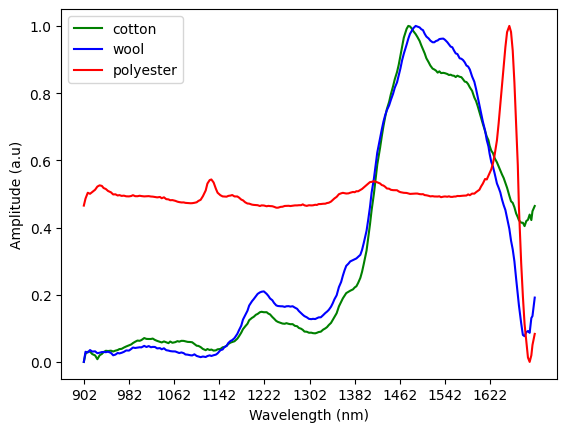

In [5]:

cotton_portion=data[0:int(np.shape(data)[0]/3)] #900x229; 900 data samples (acq), 0:227 data, 228 label data frame; data --1800x229
wool_portion=data[int(np.shape(data)[0]/3):2*int(np.shape(data)[0]/3)]
polyester_portion=data[2*int(np.shape(data)[0]/3)::]

#normalize spectral data
cp=cotton_portion.iloc[0][0:228]
wp=wool_portion.iloc[0][0:228]
pp=polyester_portion.iloc[0][0:228]

cp_n=(cp-np.min(cp))/(np.max(cp)-np.min(cp))
wp_n=(wp-np.min(wp))/(np.max(wp)-np.min(wp))
pp_n=(pp-np.min(pp))/(np.max(pp)-np.min(pp))

plt.figure(1)
#plt.title('Data')
plt.plot(wavelength[:228], cp_n, 'g', label='cotton') #cotton_portion.iloc[0][0:228]
plt.plot(wavelength[:228], wp_n, 'b', label='wool')
plt.plot(wavelength[:228], pp_n, 'r', label='polyester')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Amplitude (a.u)')
# Change x-axis tick spacing
plt.xticks(np.arange(wavelength[0], wavelength[227], step=80))  # ticks at 0, 2, 4, ..., 10
plt.legend()
plt.show()
